# UFC Fighters Segmentation using K-means

### <i> Data: UFC Roster Data <i>

<b> Description </b>: The objective of this project is to showcase the skills related to data preprocessing, data analysis, visualisation, and applying unsupervised learning algorithm in order to perform segmentation. 

<b> Data </b>: The <a href=https://www.kaggle.com/datasets/axeltorbenson/ufc-roster-datastatistics?selectufc_master_data.csv>dataset</a> was taken from Kaggle (author: Axel Torbenson). It contains UFC fighter roster along with the official rankings of each fighter, general physical information (age, weight and height), their UFC record and total MMA record. The original data was gathered from Wikipedia and the UFC website.

<b> Steps </b>: 
- The first step of this project includes loading data, cleaning and transforming it as well as choosing features for analysis.
- The second step is exploratory data analysis, where we visualize the features, look for patterns, and gain insights to make informed decisions about thhe next step.
- The third step is data preprocessing which inludes feature scaling aand normalization, dimensionality reduction, and defining the optimal number of clusters using the Elbow method.
- The fourth step includes applying K-means clustering algorithm in order to segment fighters into different categories based on all the features we have.
- Lastly, I evaluate the formed results and conduct cluster profiling.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the file
df = pd.read_csv('ufc_master_data.csv')

## 1. Data Cleaning

### 1.1. Data Inspection 

In [3]:
df.head()

,ranking,name,age,weight,gender,height,ufc_wins,ufc_loses,ufc_draws,ufc_no_contests,mma_wins,mma_loses,mma_draws,mma_no_contests
0,C,Brandon Moreno,27,125,Male,67,8,2,2.0,NaN,19.0,5.0,2.0,NaN
1,1,Deiveson Figueiredo,33,125,Male,65,9,2,1.0,NaN,20.0,2.0,1.0,NaN
2,2,Askar Askarov,29,125,Male,65,3,0,1.0,NaN,14.0,0.0,1.0,NaN
3,3,Alexandre Pantoja,31,125,Male,65,8,3,NaN,NaN,24.0,5.0,NaN,NaN
4,4,Alex Perez,29,125,Male,64,6,2,NaN,NaN,24.0,6.0,NaN,NaN


In [4]:
df.shape

(617, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ranking          177 non-null    object 
 1   name             617 non-null    object 
 2   age              617 non-null    int64  
 3   weight           617 non-null    int64  
 4   gender           617 non-null    object 
 5   height           617 non-null    int64  
 6   ufc_wins         617 non-null    int64  
 7   ufc_loses        617 non-null    int64  
 8   ufc_draws        44 non-null     float64
 9   ufc_no_contests  43 non-null     float64
 10  mma_wins         615 non-null    float64
 11  mma_loses        615 non-null    float64
 12  mma_draws        82 non-null     float64
 13  mma_no_contests  68 non-null     float64
dtypes: float64(6), int64(5), object(3)
memory usage: 67.6+ KB


In [6]:
df.isnull().sum()

ranking            440
name                 0
age                  0
weight               0
gender               0
height               0
ufc_wins             0
ufc_loses            0
ufc_draws          573
ufc_no_contests    574
mma_wins             2
mma_loses            2
mma_draws          535
mma_no_contests    549
dtype: int64

### 1.2. Choosing features

Out of the columns we have in the dataset, we will take a few of them based on the type of variables and number of missing values.

In [7]:
df.columns

Index(['ranking', 'name', 'age', 'weight', 'gender', 'height', 'ufc_wins',
       'ufc_loses', 'ufc_draws', 'ufc_no_contests', 'mma_wins', 'mma_loses',
       'mma_draws', 'mma_no_contests'],
      dtype='object')

In [8]:
df_selected = df[['age', 'height', 'ufc_wins',
       'ufc_loses', 'mma_wins', 'mma_loses', 'weight']]

df_selected.head()

,age,height,ufc_wins,ufc_loses,mma_wins,mma_loses,weight
0,27,67,8,2,19.0,5.0,125
1,33,65,9,2,20.0,2.0,125
2,29,65,3,0,14.0,0.0,125
3,31,65,8,3,24.0,5.0,125
4,29,64,6,2,24.0,6.0,125


### 1.3. Handling NaN values

Now we can handle the NaN values in the columns. As the result, two rows got dropped out.

In [9]:
df_selected.dropna(inplace=True)
df_selected.reset_index(inplace=True, drop=True)
df_selected

,age,height,ufc_wins,ufc_loses,mma_wins,mma_loses,weight
0,27,67,8,2,19.0,5.0,125
1,33,65,9,2,20.0,2.0,125
2,29,65,3,0,14.0,0.0,125
3,31,65,8,3,24.0,5.0,125
4,29,64,6,2,24.0,6.0,125
...,...,...,...,...,...,...,...
610,28,62,1,0,9.0,1.0,115
611,26,61,1,1,6.0,1.0,115
612,36,63,0,1,10.0,3.0,115
613,29,64,0,1,6.0,2.0,115


<i>Note: the height is described in inches.</i>

In [10]:
# Leave behind the 'weight' feature that we will need at the end of the analysis
fighters = df_selected.drop('weight', axis=1)
features = fighters.columns.values
features

array(['age', 'height', 'ufc_wins', 'ufc_loses', 'mma_wins', 'mma_loses'],
      dtype=object)

Since we dropped the NaN results, we can also convert some column values into proper data types.

In [11]:
fighters = fighters.astype(int)
fighters.tail()

,age,height,ufc_wins,ufc_loses,mma_wins,mma_loses
610,28,62,1,0,9,1
611,26,61,1,1,6,1
612,36,63,0,1,10,3
613,29,64,0,1,6,2
614,24,65,0,1,12,5


## 2. Data Analysis and Visualization

In [12]:
fighters.describe()

,age,height,ufc_wins,ufc_loses,mma_wins,mma_loses
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,31.128455,69.539837,4.689431,2.894309,14.626016,4.630894
std,4.063192,3.651062,4.550062,2.713259,6.633248,3.482673
min,21.000000,59.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,67.000000,1.000000,1.000000,10.000000,2.000000
50%,31.000000,69.000000,3.000000,2.000000,14.000000,4.000000
75%,34.000000,72.000000,6.000000,4.000000,18.000000,6.000000
max,44.000000,79.000000,29.000000,18.000000,59.000000,21.000000


We can see that the mean proportion between wins and losses among UFC fighters are way more balanced in UFC than in MMA in general, where wins outweigh losses significantly, which suggests that UFC is an elite promotion in the world of martial art sports.

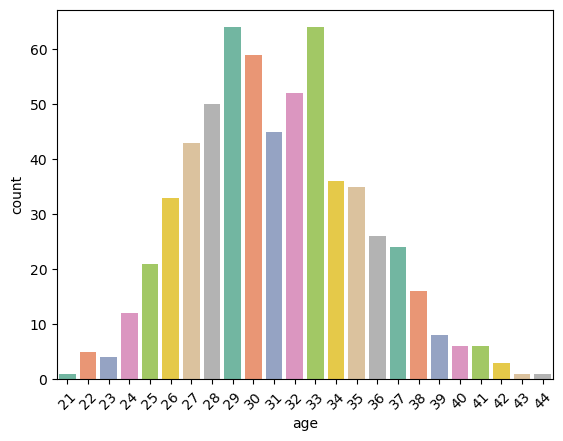

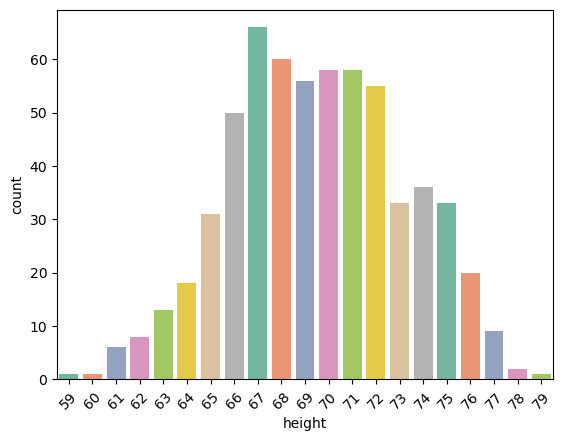

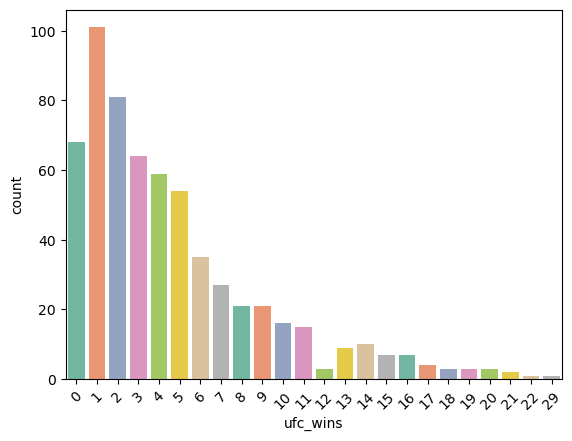

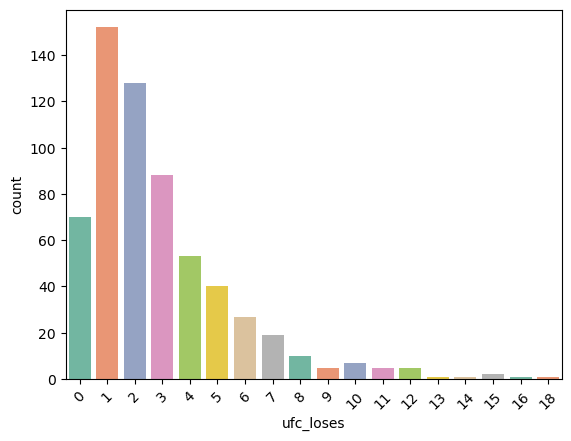

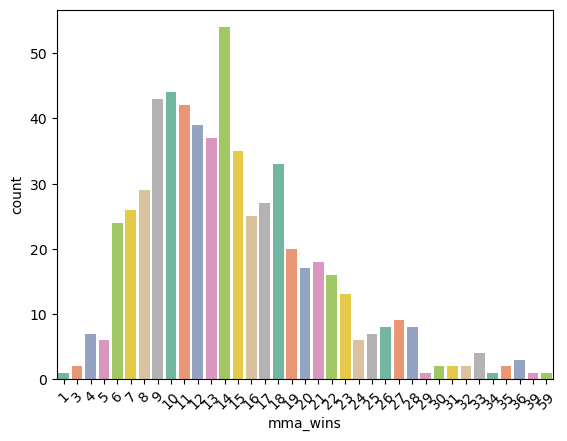

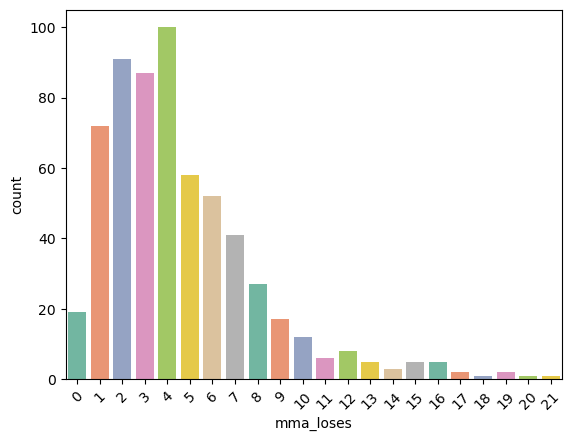

In [13]:
for f in fighters:
    sns.countplot(x=f, data=fighters, palette='Set2')
    plt.xticks(rotation=45)
    plt.show()

We can see that while frequency distributions for 'age' and 'height' features are more or less Gaussian, other columns that represent the number of wins and losses in UFC and MMA in general are right-skewed which suggests that there are way more martial art newcomers in the sport than experienced fighters. 

Let's look at the correlation amongst the features, except for the categorical ones.

<Axes: >

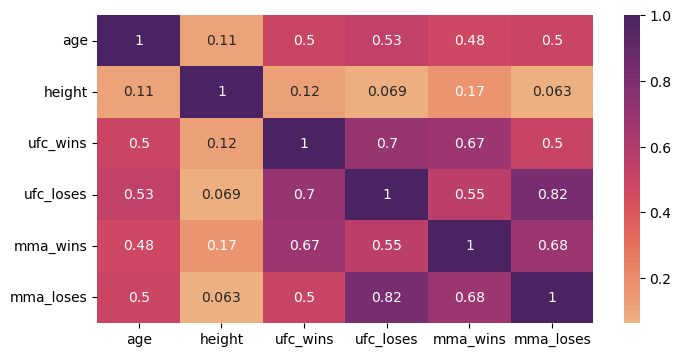

In [14]:
corr= fighters.corr()
plt.figure(figsize=(8,4))  
sns.heatmap(corr, annot=True, cmap='flare')

We can ee that, expectedly, losses and winds in UFC are highly correlated with wins and losses in MMA. There is also a considerable correlation between the age factor and wins/losses, while latter have almost no correlation with the height factor.

## 3. Data Preprocessing

In this section, we preprocess the chosen features so they are suitable for our clustering model, which includes feature scaling and normalization, dimensionality reduction, and defining a desirable number of clusters.

### 3.1. Feature Scaling

In this step, we scale and standardize features for our clustering model using StandardScaler().

In [15]:
scaler = StandardScaler()

X_scaled = fighters.copy()
# Fit and transform the selected columns
X_scaled = scaler.fit_transform(X_scaled)

# Check the standardized dataframe
print(X_scaled)

[[-1.01688909 -0.69620979  0.72817995 -0.3298752   0.65993981  0.10606972]
 [ 0.46098438 -1.24444157  0.94813608 -0.3298752   0.81081825 -0.75603878]
 [-0.5242646  -1.24444157 -0.37160067 -1.0675961  -0.09445235 -1.33077777]
 ...
 [ 1.19992112 -1.79267335 -1.03146905 -0.69873565 -0.69796608 -0.46866928]
 [-0.5242646  -1.51855746 -1.03146905 -0.69873565 -1.30147982 -0.75603878]
 [-1.75582583 -1.24444157 -1.03146905 -0.69873565 -0.39620922  0.10606972]]


### 3.2. Dimensionality reduction with PCA

In order to visualize the clustered data we will use PCA dimensionality reduction technique. It also helps us represent the most informative aspects of our features and reduce the noice of the data handling extreme cases.

In [16]:
pca = PCA(n_components=3)
pca.fit(X_scaled)
X_df = pd.DataFrame(pca.transform(X_scaled), columns=(["col1","col2", "col3"]))
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,615.0,-4.621416e-17,1.849807,-2.979703,-1.308510,-0.442077,0.829244,8.366220
col2,615.0,4.621416e-17,0.998156,-2.556240,-0.700339,0.056471,0.694259,2.731205
col3,615.0,-3.177224e-17,0.762320,-2.180984,-0.482360,-0.057721,0.458661,2.651343


In [17]:
# Get explained variance ratio
print(f"Explained variance ratio (two components): {pca.explained_variance_ratio_}")
print(f"Collective variance ratio: {((pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100).round(1)}", "%")

Explained variance ratio (two components): [0.56937008 0.1657825  0.09669778]
Collective variance ratio: 73.5 %


We can see that the two components that we got from dimensionality reduction explain about 73.5% of the variance in our dataset, which is a decent result.

### 3.3. Defining the number of clusters

In order to define the optimal number of clusters, we use the Elbow method, which involves plotting the within-cluster sum of squares against the number of clusters, where WCSS represents the sum of squared distances between each data point and its assigned cluster centroid.

In [18]:
# Get the WCSS for 10 K-means models with different numbers of clusters
wcss = []
X = X_df.values.copy()

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=15)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

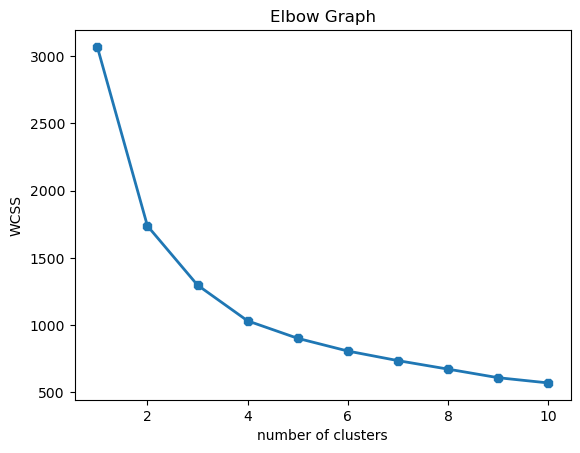

In [19]:
# Plot the Elbow graph
plt.plot(range(1,11), wcss, linewidth=2, marker='8')
plt.title('Elbow Graph')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

We can see that based on the Elbow graph the optimal number of clusters for our model is 3 or 4, so we will take the latter.

## 4. Training the K-means Model

### 4.1. Forming clusters and calculating centroids

In order to segment UFC fighters into 4 different clusters, we use K-means algorithm.

In [20]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=16)

Y = kmeans.fit_predict(X)
print(Y)

[2 3 2 3 3 2 3 2 2 3 2 3 2 2 2 3 3 2 3 0 3 1 2 2 3 3 3 3 1 1 2 3 3 3 2 0 3
 3 2 3 0 2 1 0 2 2 0 1 1 1 3 3 0 3 1 3 3 3 0 3 2 2 2 0 3 3 3 3 3 3 3 1 1 3
 0 0 3 3 2 3 0 3 3 3 1 0 3 3 0 3 3 3 3 0 3 0 1 1 0 0 1 1 0 0 3 3 0 0 0 0 0
 0 3 0 3 1 0 3 0 0 3 3 0 0 3 3 0 0 2 2 3 2 2 2 3 3 3 3 2 2 3 2 2 3 3 3 3 3
 3 3 2 2 3 2 2 2 1 2 2 2 3 3 3 3 3 2 2 2 2 3 3 3 2 3 2 2 2 1 1 3 1 3 3 1 3
 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 1 1 3 3 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3
 0 0 0 0 0 1 1 3 3 1 0 3 3 3 3 1 0 3 0 0 0 0 3 0 0 0 2 0 0 0 0 2 3 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3
 3 1 3 3 3 3 3 0 0 0 3 3 3 0 3 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 3 1 3 3 3 3 3 3 3 0 3 2 3 2 3 3 3 0 2 3 3 3 2 2 2 3
 2 2 2 0 0 0 0 0 2 2 0 0 2 2 2 0 0 2 0 0 0 0 0 0 2 0 2 2 3 0 0 0 0 0 0 1 1
 3 3 3 3 0 3 3 0 3 0 2 3 2 2 0 0 2 3 2 2 2 0 2 0 3 2 2 2 2 2 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 3 0 2 0 3 2 2 2 2 0 2 2 2 0 2 2 2 1 1 1 3 3 3 3 3 3 3 3 2 3
 0 3 0 3 2 2 2 2 0 3 3 2 

In [21]:
# Check the centroidss
centroids = kmeans.cluster_centers_
centroids

array([[-0.92278586, -0.95690327,  0.02127079],
       [ 4.80370865,  0.12242096, -0.33660887],
       [-1.18112098,  0.72777091, -0.12876241],
       [ 1.18913959,  0.07038558,  0.2252025 ]])

### 4.2. Visualizing the results

Cluster 2: 215
Cluster 3: 173
Cluster 0: 182
Cluster 1: 45


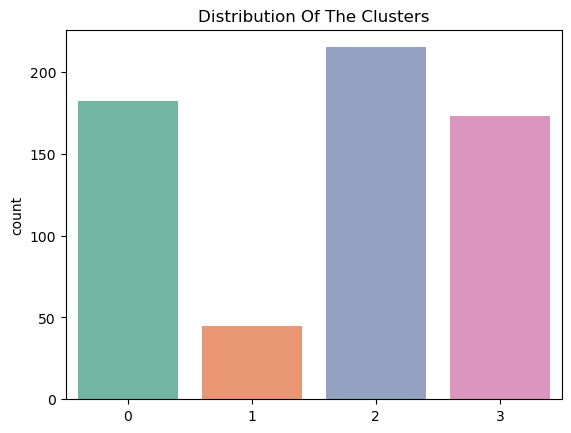

In [22]:
value_counts = Counter(Y)
for value, count in value_counts.items():
    print(f"Cluster {value}: {count}")

pl = sns.countplot(x=Y, palette="Set2")
pl.set_title("Distribution Of The Clusters")

plt.show()

The clusters 1, 2, and 3 seem to be fairly distributed, while Cluster 0 has the least number of values assigned.

Now let's visualize the clustered data we formed in a two-dimensional space.

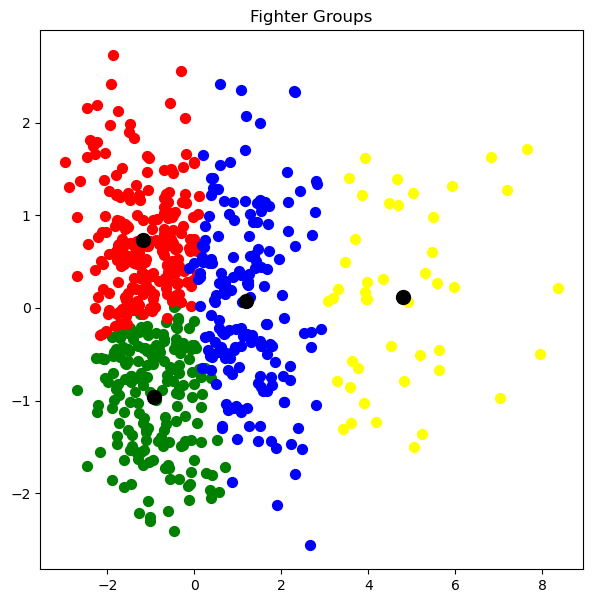

In [23]:
plt.figure(figsize=(7,7))
plt.scatter(X[Y==0,0], X[Y==0,1], s=50, c='green', label='Cluster 1')
plt.scatter(X[Y==1,0], X[Y==1,1], s=50, c='yellow', label='Cluster 2')
plt.scatter(X[Y==2,0], X[Y==2,1], s=50, c='red', label='Cluster 3')
plt.scatter(X[Y==3,0], X[Y==3,1], s=50, c='blue', label='Cluster 4')

# Plot the centroids
plt.scatter(centroids[:,0], centroids[:,1], s=100, c='black', label='centroids')
plt.title('Fighter Groups')

plt.show()

We can see that clusters 0, 2, and 3 are quite tight while Cluster 1 is rather sparse and small.

3D Visualization let us see the formed clusters in a more visually detailed and voluminous way.

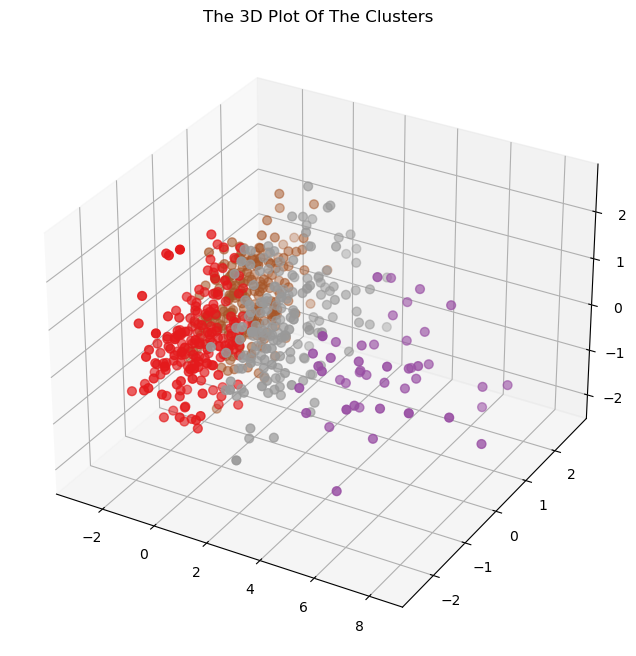

In [24]:
x = X_df["col1"]
y = X_df["col2"]
z = X_df["col3"]

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=Y, marker='o', cmap = "Set1" )
ax.set_title("The 3D Plot Of The Clusters")
plt.show()

We can see that in some places the data points are a bit too sparse, but that's because the number of training examples - UFC fighters - is relatively small. Nevertheless, we can spot four different clusters, each representing certain feature properties.

## 5. Evaluating the Model: Profiling

Finally, we can evaluate the four clusters that we formed by studying the patterns and profiling the fighters in each of them based on the chosen features.

In [25]:
fighters_k = fighters.copy()
fighters_k['clusters'] = pd.DataFrame(Y)
fighters_k.iloc[40:70, :]

,age,height,ufc_wins,ufc_loses,mma_wins,mma_loses,clusters
40,33,72,7,0,14,2,0
41,30,67,7,3,15,4,2
42,35,71,16,10,22,10,1
43,27,70,5,0,14,0,0
44,28,69,4,1,11,2,2
45,29,68,5,0,15,0,2
46,30,71,7,3,14,3,0
47,33,70,13,10,18,12,1
48,32,70,19,8,31,8,1
49,32,69,21,6,28,6,1


In [26]:
K1 = fighters_k.loc[fighters_k['clusters']==0][features]
K2 = fighters_k.loc[fighters_k['clusters']==1][features]
K3 = fighters_k.loc[fighters_k['clusters']==2][features]
K4 = fighters_k.loc[fighters_k['clusters']==3][features]

print(K1.describe())
print(K2.describe())
print(K3.describe())
print(K4.describe())

              age      height   ufc_wins   ufc_loses    mma_wins   mma_loses
count  182.000000  182.000000  182.00000  182.000000  182.000000  182.000000
mean    29.824176   72.697802    2.60989    1.472527   11.796703    2.846154
std      3.205980    2.190359    2.19656    1.095855    4.296650    1.745859
min     22.000000   69.000000    0.00000    0.000000    1.000000    0.000000
25%     27.000000   71.000000    1.00000    1.000000    9.000000    1.250000
50%     30.000000   72.000000    2.00000    1.000000   11.000000    3.000000
75%     32.000000   74.000000    4.00000    2.000000   14.000000    4.000000
max     41.000000   78.000000   10.00000    5.000000   28.000000    8.000000
             age     height   ufc_wins  ufc_loses   mma_wins  mma_loses
count  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000
mean   37.288889  70.933333  15.044444   9.555556  28.466667  12.577778
std     2.920322   3.179480   4.425934   3.026816   6.870887   3.957093
min    32.000000  6

### Profiling fighter groups:

#### Cluster 1:
- Young fighters
- UFC newcomers
- Mostly middle-weight, heavy-weight categories
- Tall fighters

#### Cluster 2:
- Highly experienced both in UFC and MMA
- Mostly fighters of mature age
- Weight categories vary significantly
- Mostly tall fighters

#### Cluster 3:
- Young fighters
- UFC newcomers
- Mostly light-weight, middle-weight categories
- Fighters of smaller height

#### Cluster 4:
- Very experienced in MMA, decent experience in UFC
- Mostly mature fighters
- Weight categories vary significantly
- Middle-height fighters